# Project: Text Classification

Goal: to build a text classification model on song lyrics and to predict the artist from a piece of text.  
Lyrics dataset: 20 songs Radiohead, 20 songs Arctic Monkeys

In [85]:
import pandas as pd
import numpy as np
import string
import requests
import re
from bs4 import BeautifulSoup
from lxml import html
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

import nltk
from nltk.probability import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from collections import defaultdict
from pymorphy2 import MorphAnalyzer
from collections import Counter
from nltk.util import ngrams

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import spacy
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('songs_40.csv',
                 lineterminator='\n')

In [3]:
data['songs']

0     Religious iconography giving you the creeps?\r...
1     One, two, three, four\r \r She looks like fun\...
2     I want an interesting synonym\r To describe th...
3     Still got pictures of friends on the wall\r I ...
4     So when you gaze at planet earth from outer sp...
5     Mad sounds in your ears, they make you feel al...
6     Well the times are so a'changing\r Baby even w...
7     Open Sesame. (We've places to go) We've people...
8     You got your H.P. Lovecraft\r Your Edgar Allan...
9     Stop making the eyes at me\r I'll stop making ...
10    Stop making the eyes at me\r I'll stop making ...
11    She's thunderstorms\r Lying on her front\r Up ...
12    Break a mirror\r Roll the dice\r Run with scis...
13    Library pictures of the quickening canoe\r The...
14    Caricatures of your wrecking ball \r In my min...
15    Topless models\r Doing semaphore\r Wave their ...
16    I etched a face of a stopwatch\r On the back o...
17    Do you still feel younger than you thought

In [4]:
# смотрим на самые частые слова в описании
text = ' '.join(data['songs'].values)
text_trigrams = [i for i in ngrams(text.split(' '), 5)]
text_trigrams
my_list = Counter(text_trigrams).most_common(50)
my_list[:20]

[(('(Go', 'on', 'and', 'shoot', "'em)\r"), 33),
 (('Broken', 'hearts', 'make', 'it', 'rain\r'), 17),
 (('hearts', 'make', 'it', 'rain\r', 'Broken'), 16),
 (('Jew', '(Go', 'on', 'and', 'shoot'), 16),
 (('on', 'and', 'shoot', "'em)\r", '(Go'), 16),
 (('and', 'shoot', "'em)\r", '(Go', 'on'), 16),
 (('shoot', "'em)\r", '(Go', 'on', 'and'), 16),
 (("'em)\r", '(Go', 'on', 'and', 'shoot'), 16),
 (('make', 'it', 'rain\r', 'Broken', 'hearts'), 15),
 (('it', 'rain\r', 'Broken', 'hearts', 'make'), 15),
 (('rain\r', 'Broken', 'hearts', 'make', 'it'), 15),
 (('on', 'and', 'shoot', "'em)\r", 'Jew'), 15),
 (('and', 'shoot', "'em)\r", 'Jew', '(Go'), 15),
 (('shoot', "'em)\r", 'Jew', '(Go', 'on'), 15),
 (("'em)\r", 'Jew', '(Go', 'on', 'and'), 15),
 (('I', 'bet', 'that', 'you', 'look'), 12),
 (('bet', 'that', 'you', 'look', 'good'), 12),
 (('that', 'you', 'look', 'good', 'on'), 12),
 (('you', 'look', 'good', 'on', 'the'), 12),
 (('look', 'good', 'on', 'the', 'dance'), 12)]

In [5]:
mystem = Mystem() 
english_stopwords = stopwords.words("english")
#english_stopwords.remove('yeah')

def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in english_stopwords\
              and token != " " \
              and token.strip() not in punctuation+'«»“•' \
              and '\n' not in token]
    
    text = " ".join(tokens)
    
    return text

In [6]:
data.songs = data.songs.apply(preprocess_text)

In [7]:
data.songs

0     religious iconography giving creeps feel rough...
1     one two three four looks like fun looks like f...
2     want interesting synonym describe thing say gr...
3     still got pictures friends wall suppose really...
4     gaze planet earth outer space wipe stupid look...
5     mad sounds ears make feel alright bring back l...
6     well times changing baby even live press pause...
7     open sesame places go people see let put em ho...
8     got h p lovecraft edgar allan poe got unkind r...
9     stop making eyes stop making eyes surprises re...
10    stop making eyes stop making eyes surprises re...
11    thunderstorms lying front wall thunderstorms f...
12    break mirror roll dice run scissors chip fryer...
13    library pictures quickening canoe first kind g...
14    caricatures wrecking ball mind time wanna dams...
15    topless models semaphore wave flags walks get ...
16    etched face stopwatch back raindrop swap sand ...
17    still feel younger thought would darling s

## Spacy library 

Tasks:
- Use the CountVectorizer from Scikit to transform your corpus into a matrix.
- Normalize the counts using the TfidfTransformer.
- Print the total vocabulary size (an attribute of the vectorizer).
- Try different values for the CountVectorizer (e.g. stop_words, min_df, ngram_range).
- Build a scikit-learn pipeline of the two transformers.
- Write your own TF-IDF algorithm.

In [8]:
# splitting the data
X = data['songs']
y = data['artist']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [10]:
X_train.shape,y_train.shape

((31,), (31,))

In [11]:
data['artist'].value_counts()

Arctic Monkeys    21
Radiohead         21
Name: artist, dtype: int64

In [12]:
cv = CountVectorizer(stop_words='english', max_df=0.8)# substitute stopwords 
X_cv = cv.fit_transform(X)
X_df = pd.DataFrame(X_cv.todense(), columns=cv.get_feature_names_out(), index=y)
X_df.head()

,180,1984,accepted,acrobatic,admit,afraid,afternoon,afternoons,age,agree,...,write,writing,wrong,x46,ya,yeah,years,yesterday,younger,youth
artist,,,,,,,,,,,,,,,,,,,,,
Arctic Monkeys,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Arctic Monkeys,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arctic Monkeys,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Arctic Monkeys,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
Arctic Monkeys,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0


In [13]:
X_cv.shape

(42, 1126)

In [14]:
cv.get_feature_names()

['180',
 '1984',
 'accepted',
 'acrobatic',
 'admit',
 'afraid',
 'afternoon',
 'afternoons',
 'age',
 'agree',
 'ah',
 'air',
 'alive',
 'allan',
 'allen',
 'alley',
 'alright',
 'amazing',
 'amber',
 'america',
 'american',
 'amputate',
 'ancient',
 'angle',
 'answer',
 'answering',
 'anymore',
 'anytime',
 'apart',
 'appliances',
 'armor',
 'arms',
 'arts',
 'ascension',
 'ask',
 'attics',
 'attitudes',
 'aura',
 'avenues',
 'away',
 'babe',
 'baby',
 'ball',
 'balls',
 'band',
 'bang',
 'banging',
 'bar',
 'bars',
 'basic',
 'bath',
 'batphone',
 'battery',
 'battleground',
 'beach',
 'beams',
 'bear',
 'beauty',
 'beings',
 'beliefs',
 'believe',
 'belong',
 'beneath',
 'berserk',
 'bet',
 'better',
 'big',
 'birth',
 'bitch',
 'bite',
 'bittersweet',
 'black',
 'blame',
 'blank',
 'bleak',
 'blind',
 'blinds',
 'block',
 'blocking',
 'blood',
 'blossom',
 'blow',
 'blowing',
 'blown',
 'blue',
 'blunderbus',
 'blush',
 'bonfire',
 'booth',
 'boots',
 'born',
 'bought',
 'bows',
 

In [15]:
cv.vocabulary_

{'religious': 768,
 'iconography': 474,
 'giving': 385,
 'creeps': 202,
 'feel': 322,
 'rougher': 793,
 'disco': 244,
 'lizard': 553,
 'tongue': 1001,
 'cheek': 152,
 'rise': 782,
 'machines': 577,
 'admit': 4,
 'gave': 379,
 'momentarily': 616,
 'believe': 60,
 'hand': 418,
 'harsh': 430,
 'reality': 752,
 'gloved': 389,
 'way': 1079,
 'scoop': 812,
 'watch': 1075,
 'stay': 921,
 'love': 567,
 'science': 809,
 'fiction': 325,
 'reflections': 764,
 'silver': 857,
 'screen': 814,
 'strange': 933,
 'societies': 880,
 'swamp': 959,
 'monster': 618,
 'hard': 427,
 'connectivity': 186,
 'ascension': 33,
 'cream': 199,
 'mass': 588,
 'panic': 672,
 'distant': 248,
 'future': 375,
 'colony': 172,
 'quantitative': 736,
 'easing': 279,
 'want': 1069,
 'make': 580,
 'simple': 858,
 'point': 711,
 'peace': 684,
 'sexy': 835,
 'obvious': 655,
 'highlight': 452,
 'dangers': 213,
 'send': 824,
 'hidden': 449,
 'messages': 602,
 'got': 401,
 'world': 1109,
 'wire': 1102,
 'little': 547,
 'mirror': 61

In [16]:
tf = TfidfTransformer()# apply TF-IDF Vectorizer
X_norm = tf.fit_transform(X_cv)# creating sparse matrix 

In [17]:
print(X_norm)

  (0, 1116)	0.0918518532167175
  (0, 1109)	0.06704647917418163
  (0, 1102)	0.0918518532167175
  (0, 1079)	0.4269785136288218
  (0, 1075)	0.08269692770608662
  (0, 1069)	0.05139603064227665
  (0, 1063)	0.07116308560480364
  (0, 1016)	0.07116308560480364
  (0, 1001)	0.07116308560480364
  (0, 981)	0.07116308560480364
  (0, 959)	0.0918518532167175
  (0, 933)	0.0918518532167175
  (0, 921)	0.0918518532167175
  (0, 884)	0.08269692770608662
  (0, 880)	0.0918518532167175
  (0, 858)	0.0918518532167175
  (0, 857)	0.0918518532167175
  (0, 835)	0.0918518532167175
  (0, 824)	0.0918518532167175
  (0, 814)	0.0918518532167175
  (0, 812)	0.0918518532167175
  (0, 809)	0.36740741286687
  (0, 793)	0.0918518532167175
  (0, 782)	0.0918518532167175
  (0, 768)	0.0918518532167175
  :	:
  (41, 998)	0.07364866454984889
  (41, 968)	0.14729732909969778
  (41, 931)	0.14729732909969778
  (41, 899)	0.13261612204075102
  (41, 878)	0.07364866454984889
  (41, 863)	0.057059994289657544
  (41, 767)	0.7364866454984889
  (41

In [18]:
#transforming X_test
X_norm_trans=tf.transform(X_norm).toarray()
X_norm_trans

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.07012903],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.08484369, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [19]:
# converting sparse matrix into a dense matrix to view it effectively
tf_vectors=pd.DataFrame(X_norm.todense().round(2), columns=cv.get_feature_names()) 

In [20]:
tf_vectors.head()

,180,1984,accepted,acrobatic,admit,afraid,afternoon,afternoons,age,agree,...,write,writing,wrong,x46,ya,yeah,years,yesterday,younger,youth
0,0.0,0.0,0.0,0.0,0.09,0.0,0.0,0.0,0.00,0.0,...,0.09,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
2,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.07
3,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.12,0.0,...,0.00,0.12,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
4,0.0,0.0,0.1,0.0,0.00,0.0,0.0,0.0,0.00,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.28,0.0,0.0,0.00


In [86]:
def print_evaluations(ytrue, ypred, model):
    """
    Function that compares several scores for a given model
    and returns the confusion matrix.
    """
    pos_label =[['Arctic Monkeys', 'Radiohead']]
    print(f'How does model {model} score:')
    print(f'The accuracy of the model is: {round(accuracy_score(ytrue, ypred), 3)}')
    print(f'''The precision of the model is: {round(precision_score(ytrue, ypred,average='weighted',labels=["Radiohead"] ), 3)}''')
    print(f'''The recall of the model is: {round(recall_score(ytrue, ypred, average='weighted', labels=["Radiohead"]), 3)}''')
    print(f'''The f1-score of the model is: {round(f1_score(ytrue, ypred,average='weighted', labels=["Radiohead"]), 3)}''')
    cm = confusion_matrix(ytrue, ypred)
    return cm, precision_score(ytrue, ypred,average='weighted',labels=["Radiohead"]) , recall_score(ytrue, ypred, average='weighted', labels=["Radiohead"])

In [87]:
def plot_heatmap(cm):
    
    """
    Function that plots a heatmap based on a correlation matrix
    """
    
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True,  cbar=True, \
                cmap = 'GnBu', vmax = 200,\
               xticklabels=['Radiohead', 'Arctic Monkeys'],\
                yticklabels=['Radiohead', 'Arctic Monkeys'],\
                linecolor='white',\
               linewidth=2, square = True, fmt = '.0f', robust = True); 
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    ax.set_xticklabels(['Radiohead', 'Arctic Monkeys'])

### LogisticRegression

In [22]:
X = X_norm
y = data['artist']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [24]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)
model_LR.score(X_train, y_train),model_LR.score(X_test, y_test)

(1.0, 0.6363636363636364)

In [25]:
# cross validation
val = cross_val_score(model_LR, X_train, y_train, cv=5, scoring='accuracy')
print("cross validation accuracy: ", val.round(2))

cross validation accuracy:  [0.71 0.5  0.5  0.67 0.5 ]


In [89]:
y_pred_LR = model_LR.predict(X_test)  

In [27]:
model_LR.predict_proba(X_train)

array([[0.58186744, 0.41813256],
       [0.59061714, 0.40938286],
       [0.59295825, 0.40704175],
       [0.40259443, 0.59740557],
       [0.5997734 , 0.4002266 ],
       [0.38625011, 0.61374989],
       [0.38585622, 0.61414378],
       [0.58146861, 0.41853139],
       [0.38437799, 0.61562201],
       [0.39224246, 0.60775754],
       [0.38733436, 0.61266564],
       [0.58679029, 0.41320971],
       [0.59636843, 0.40363157],
       [0.38029229, 0.61970771],
       [0.39043316, 0.60956684],
       [0.57410994, 0.42589006],
       [0.37212829, 0.62787171],
       [0.37536726, 0.62463274],
       [0.59162563, 0.40837437],
       [0.40724313, 0.59275687],
       [0.37404048, 0.62595952],
       [0.58762101, 0.41237899],
       [0.59678454, 0.40321546],
       [0.60357381, 0.39642619],
       [0.38330475, 0.61669525],
       [0.36791202, 0.63208798],
       [0.5730113 , 0.4269887 ],
       [0.58594409, 0.41405591],
       [0.39564361, 0.60435639],
       [0.39817209, 0.60182791],
       [0.

In [90]:
cm_LR, precision_LR, recall_LR = print_evaluations(y_test, y_pred_LR, 'Logistic Regression')

How does model Logistic Regression score:
The accuracy of the model is: 0.909
The precision of the model is: 0.889
The recall of the model is: 1.0
The f1-score of the model is: 0.941


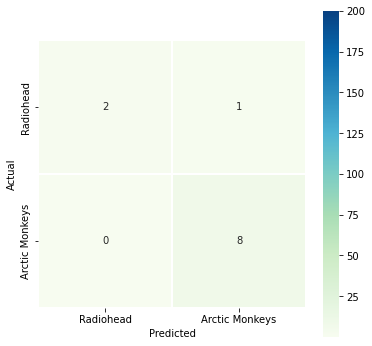

In [92]:
plot_heatmap(cm_LR)

### RandomForest

In [62]:
X = X_norm
y = data['artist']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [64]:
model_RF = RandomForestClassifier()
model_RF.fit(X_train, y_train)
round(model_RF.score(X_train, y_train),2),round(model_LR.score(X_test, y_test),2)

(1.0, 0.91)

In [65]:
# cross validation
val = cross_val_score(model_RF, X_train, y_train, cv=5, scoring='accuracy')
print("cross validation accuracy: ", val.round(2))

cross validation accuracy:  [0.57 1.   0.33 0.83 0.33]


In [66]:
model_RF = RandomForestClassifier(max_depth=5, n_estimators=10)
model_RF.fit(X_train, y_train)
round(model_RF.score(X_train, y_train),2),round(model_RF.score(X_test, y_test),2)

(0.94, 0.36)

In [93]:
y_pred_RF = model_RF.predict(X_test)

In [68]:
model_RF.predict_proba(X_train)

array([[0.53869272, 0.46130728],
       [0.72342956, 0.27657044],
       [0.73395588, 0.26604412],
       [0.92244917, 0.07755083],
       [0.72869272, 0.27130728],
       [0.72342956, 0.27657044],
       [0.92244917, 0.07755083],
       [0.82342956, 0.17657044],
       [0.38327476, 0.61672524],
       [0.81104566, 0.18895434],
       [0.28415196, 0.71584804],
       [0.53869272, 0.46130728],
       [0.81104566, 0.18895434],
       [0.20946524, 0.79053476],
       [0.7535018 , 0.2464982 ],
       [0.45535939, 0.54464061],
       [0.62869272, 0.37130728],
       [0.74535939, 0.25464061],
       [0.28415196, 0.71584804],
       [0.21098039, 0.78901961],
       [0.72869272, 0.27130728],
       [0.28167518, 0.71832482],
       [0.28992776, 0.71007224],
       [0.9057825 , 0.0942175 ],
       [0.6688888 , 0.3311112 ],
       [0.19519092, 0.80480908],
       [0.65124174, 0.34875826],
       [0.199857  , 0.800143  ],
       [0.53869272, 0.46130728],
       [0.8157825 , 0.1842175 ],
       [0.

In [94]:
cm_RF, precision_RF, recall_RF = print_evaluations(y_test, y_pred_RF, 'RandomForest')

How does model RandomForest score:
The accuracy of the model is: 0.364
The precision of the model is: 1.0
The recall of the model is: 0.125
The f1-score of the model is: 0.222


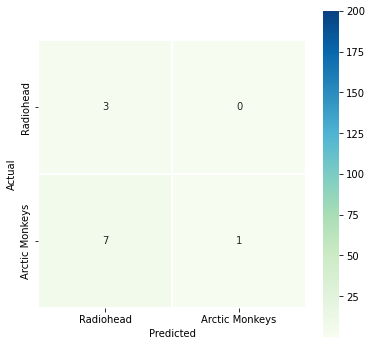

In [95]:
plot_heatmap(cm_RF)

### Naive Bayes

In [70]:
model_NB = MultinomialNB()
model_NB.fit(X_train, y_train)
round(model_NB.score(X_train, y_train),2),round(model_NB.score(X_test, y_test),2)

(1.0, 0.27)

In [76]:
y_pred_NB = model_NB.predict(X_test)

In [73]:
model_NB.predict_proba(X_train)

array([[0.7458419 , 0.2541581 ],
       [0.75218324, 0.24781676],
       [0.75698174, 0.24301826],
       [0.76520617, 0.23479383],
       [0.76983244, 0.23016756],
       [0.76204953, 0.23795047],
       [0.74601975, 0.25398025],
       [0.74243239, 0.25756761],
       [0.36645804, 0.63354196],
       [0.75792966, 0.24207034],
       [0.40679818, 0.59320182],
       [0.35199385, 0.64800615],
       [0.76037444, 0.23962556],
       [0.35752099, 0.64247901],
       [0.73132221, 0.26867779],
       [0.3658645 , 0.6341355 ],
       [0.74638925, 0.25361075],
       [0.75285826, 0.24714174],
       [0.37679418, 0.62320582],
       [0.3489969 , 0.6510031 ],
       [0.76503713, 0.23496287],
       [0.38107448, 0.61892552],
       [0.40585964, 0.59414036],
       [0.72626973, 0.27373027],
       [0.76150217, 0.23849783],
       [0.32297827, 0.67702173],
       [0.75517144, 0.24482856],
       [0.36757657, 0.63242343],
       [0.37078313, 0.62921687],
       [0.72382413, 0.27617587],
       [0.

In [98]:
cm_NB, precision_NB, recall_NB = print_evaluations(y_test, y_pred_NB, 'Naive Bayes')

How does model Naive Bayes score:
The accuracy of the model is: 0.273
The precision of the model is: 0.0
The recall of the model is: 0.0
The f1-score of the model is: 0.0


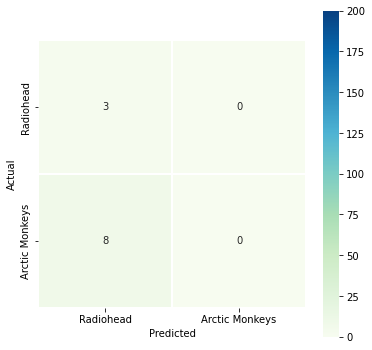

In [99]:
plot_heatmap(cm_NB)

### Oversampling

In [42]:
ros = RandomOverSampler(sampling_strategy={'Radiohead':20})

In [43]:
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [44]:
np.unique(y_ros, return_counts=True)

(array(['Arctic Monkeys', 'Radiohead'], dtype=object), array([15, 20]))

In [111]:
model_RF.fit(X_ros, y_ros)

RandomForestClassifier(max_depth=5, n_estimators=10)

In [46]:
ypred_ros = model_RF.predict(X_test)
ypred_ros

array(['Radiohead', 'Radiohead', 'Radiohead', 'Radiohead', 'Radiohead',
       'Radiohead', 'Radiohead', 'Radiohead', 'Radiohead',
       'Arctic Monkeys', 'Radiohead'], dtype=object)

In [100]:
cm_ros, precision_ros, recall_ros = print_evaluations(y_test, ypred_ros, 'RandomOverSampler')

How does model RandomOverSampler score:
The accuracy of the model is: 0.818
The precision of the model is: 0.8
The recall of the model is: 1.0
The f1-score of the model is: 0.889


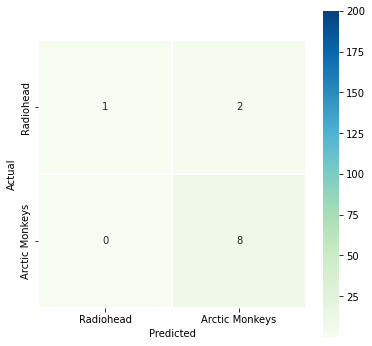

In [101]:
plot_heatmap(cm_ros)

### Undersampling

In [47]:
rus = RandomUnderSampler(sampling_strategy={"Radiohead":10})
nm = NearMiss(sampling_strategy={"Radiohead":10})

In [48]:
X_rus, y_rus = rus.fit_resample(X_train, y_train)


In [49]:
model_RF.fit(X_rus, y_rus)

RandomForestClassifier(max_depth=5, n_estimators=10)

In [50]:
y_pred_rus = model_RF.predict(X_test)
y_pred_rus

array(['Arctic Monkeys', 'Arctic Monkeys', 'Arctic Monkeys',
       'Arctic Monkeys', 'Arctic Monkeys', 'Arctic Monkeys',
       'Arctic Monkeys', 'Arctic Monkeys', 'Arctic Monkeys',
       'Arctic Monkeys', 'Arctic Monkeys'], dtype=object)

In [102]:
cm_rus, precision_rus, recall_rus = print_evaluations(y_test, y_pred_rus, 'RandomUnderSampler')

How does model RandomUnderSampler score:
The accuracy of the model is: 0.273
The precision of the model is: 0.0
The recall of the model is: 0.0
The f1-score of the model is: 0.0


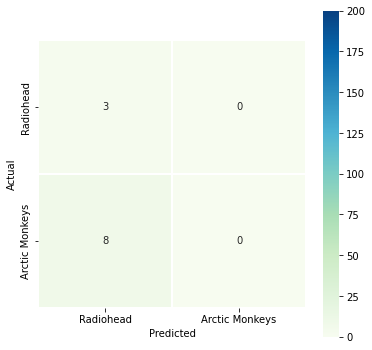

In [108]:
plot_heatmap(cm_rus)

In [107]:
X_nm, y_nm = nm.fit_resample(X_train, y_train)
model_RF.fit(X_nm, y_nm)
y_pred_nm = model_RF.predict(X_test)
y_pred_nm

array(['Arctic Monkeys', 'Radiohead', 'Radiohead', 'Radiohead',
       'Arctic Monkeys', 'Arctic Monkeys', 'Arctic Monkeys',
       'Arctic Monkeys', 'Arctic Monkeys', 'Arctic Monkeys',
       'Arctic Monkeys'], dtype=object)

In [109]:
cm_nm, precision_nm, recall_nm = print_evaluations(y_test, y_pred_nm, 'NearMiss')

How does model NearMiss score:
The accuracy of the model is: 0.545
The precision of the model is: 1.0
The recall of the model is: 0.375
The f1-score of the model is: 0.545


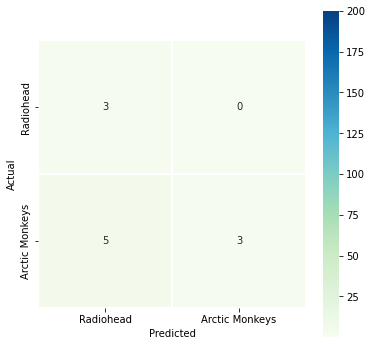

In [110]:
plot_heatmap(cm_nm)

### Summary

In [ ]:
pd.DataFrame({"precision":[precision, precision_rus, precision_nm, precision_ros, precision_smote],
              "recall":[recall, recall_rus, recall_nm, recall_ros, recall_smote]},
              index=["original", "rus", "nearmiss", "ros", "smote"],)

### Prediction based on the input text

In [52]:
def predict(lyrics_input):
    song = [lyrics_input]
    counts = cv.transform(song)
    tfcounts = tf.transform(counts)
    
    lyrics_final= pd.DataFrame(counts.todense().round(2), columns=cv.get_feature_names_out())

    prediction = model_RF.predict(lyrics_final)
    print(prediction)

In [53]:
lyrics_input = input("Your lyrics: ")

Your lyrics: dancing shoes


In [54]:
predict(lyrics_input)

['Arctic Monkeys']


In [55]:
song = [lyrics_input]
counts = cv.transform(song)
tfcounts = tf.transform(counts)
model_RF.predict_proba(tfcounts)#.round(2)

array([[0.54442557, 0.45557443]])

In [56]:
model_RF.predict(tfcounts)

array(['Arctic Monkeys'], dtype=object)

In [112]:
pd.DataFrame(
    {
        "precision": [
            precision_LR, precision_RF, precision_NB,
            precision_ros, precision_rus, precision_nm
        ],
        "recall": [
            recall_LR,
            recall_RF,
            recall_NB,
            recall_ros,
            recall_rus,
            recall_nm,
        ]
    },
    index=["LR", "RF", "NB", "ROS","RUS", "NM"]
)

,precision,recall
LR,0.888889,1.000
RF,1.000000,0.125
NB,0.000000,0.000
ROS,0.800000,1.000
RUS,0.000000,0.000
NM,1.000000,0.375


### Word Cloud

In [57]:
with open("/Users/Varvara/spiced_working files/arctic_monkeys_songs/arctic+monkeys_mardy+bum.html", "r", encoding='utf-8') as f:
    html_string= f.read()
    
soup = BeautifulSoup(html_string)
text = soup.find(attrs={'class': 'lyric-body'}).text

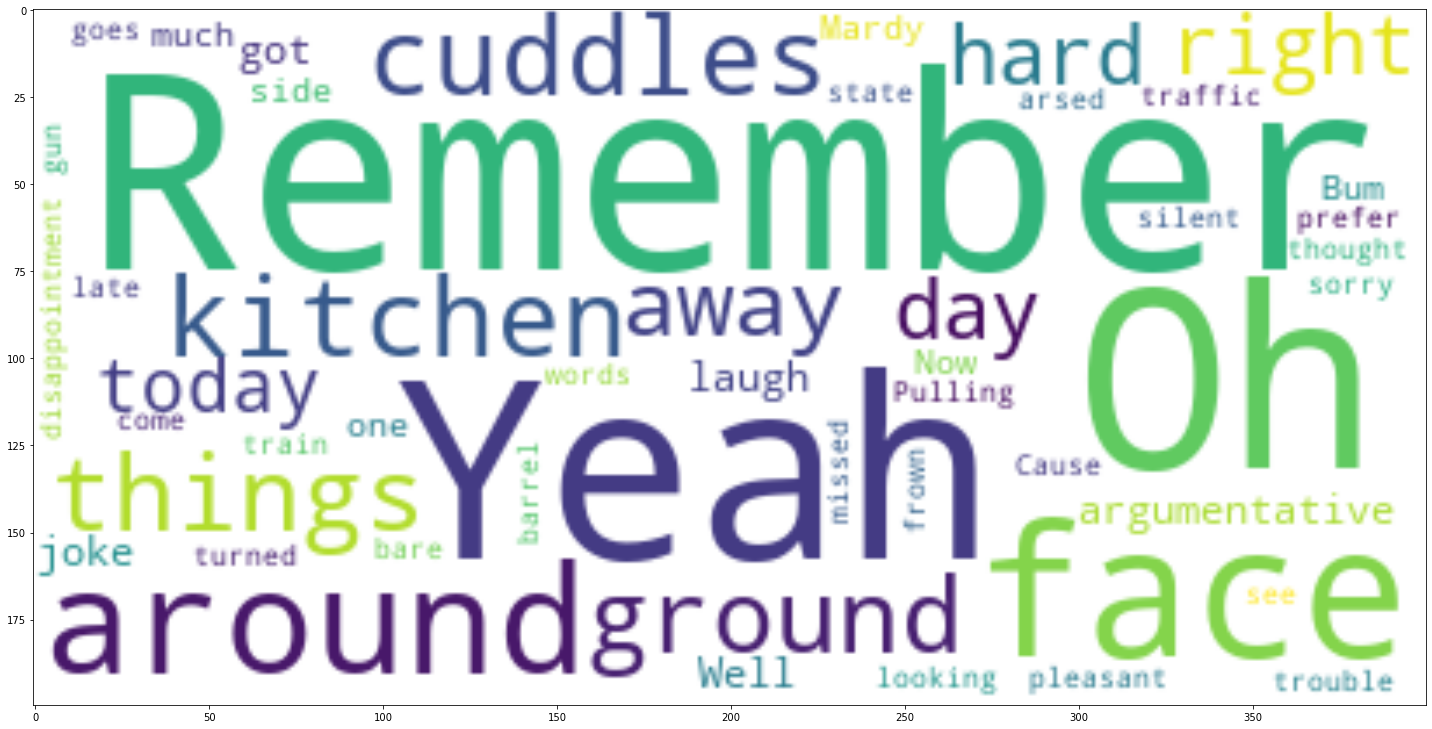

In [58]:
mask = np.zeros((500, 600, 3), np.uint8)
mask[150:350,150:350,:] = 255  # masked out area
cloud = wordcloud.WordCloud(background_color="white",
                max_words=50,
                #mask=mask,
                collocations=False,  # calculates frequencies
                contour_color='steelblue').generate(text)
                # stop words are removed!

plt.figure(figsize = (20,20))
plt.imshow(cloud, interpolation='bilinear')
plt.tight_layout(pad = 1.08)# important feature(without it there is a empty space in the middle)
plt.savefig('cloud.png')
plt.show()